In [4]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import jax.numpy as jnp
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
path_prefix = './data/MNIST/'

# Reading the image files
train_images = read_idx(path_prefix+'train-images-idx3-ubyte/train-images-idx3-ubyte')
test_images = read_idx(path_prefix+'t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')

# Reading the label files
train_labels = read_idx(path_prefix+'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_labels = read_idx(path_prefix+'t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

print(f'Training images shape: {train_images.shape}')
print(f'Training labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [69]:
from src.PCA import PCA

pca = PCA(n_components=2)

pca.fit(train_images.reshape(train_images.shape[0], -1))

pca.transform(train_images.reshape(train_images.shape[0], -1))

Array([[ 880.73157 ,  329.95056 ],
       [1768.5175  ,  312.133   ],
       [ 704.94934 , -374.8967  ],
       ...,
       [ 578.74524 , -142.80147 ],
       [ 887.4051  ,   22.867981],
       [ 583.36273 ,   41.995262]], dtype=float32)

In [3]:
train_images_pca = pca.transform(train_images.reshape(train_images.shape[0], -1))

In [17]:
from src.PCA import KPCA

def to_rgba(image, cmap='gray'):
    from matplotlib.cm import get_cmap
    cmap = get_cmap(cmap)
    rgba_img = cmap(image)
    rgba_img[..., 3] = image / 255.0
    return rgba_img

def train_and_plot(sample, kernel, n_show=500):
    kpca = KPCA(n_components=2, kernel=kernel)
    kpca.fit(sample)
    
    idx = np.random.choice(sample.shape[0], n_show)
    transformed = kpca.transform(idx)
    print(transformed.shape)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(transformed[:, 0], transformed[:, 1], alpha=0)
    
    sample_show = sample[idx]
    sample_show = sample_show.reshape(-1, 28, 28)
    print(sample_show.shape)
        
    for i, coords in enumerate(transformed):
        x, y = coords
        img = sample_show[i]
        rgba_img = to_rgba(img)
        imagebox = OffsetImage(rgba_img, zoom=0.6)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('MNIST Images on PCA Plane')
    plt.show()

In [59]:
def rbf_kernel(gamma, z):
    def kernel(x, y):
        return jnp.exp(-gamma * jnp.linalg.norm(x - y) ** 2)/z
    return kernel

def exp_kernel(sigma):
    def kernel(x, y):
        return jnp.exp(-jnp.linalg.norm(x - y) / sigma)
    return kernel

def poly_kernel(d):
    def kernel(x, y):
        return (jnp.dot(x, y) + 1) ** d
    return kernel

def sigmoid_kernel(a, r):
    def kernel(x, y):
        return jnp.tanh(a * jnp.dot(x, y) + r)
    return kernel

(500, 2)
(500, 28, 28)


/tmp/ipykernel_7973/492670265.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


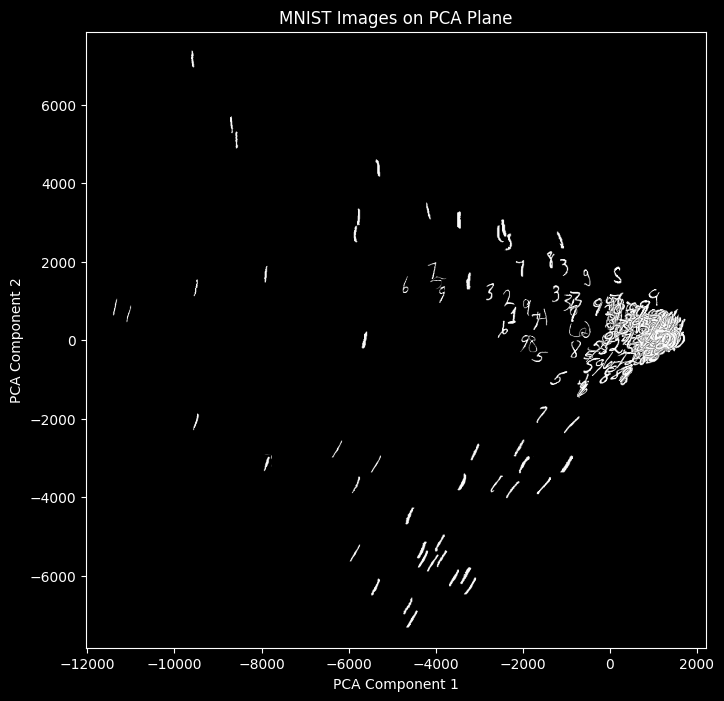

In [21]:
sample_size = 1000
sample = train_images.reshape(train_images.shape[0], -1)[:sample_size]
train_and_plot(sample, rbf_kernel(0.000001, 1), n_show=500)

(500, 2)
(500, 28, 28)


/tmp/ipykernel_7973/492670265.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


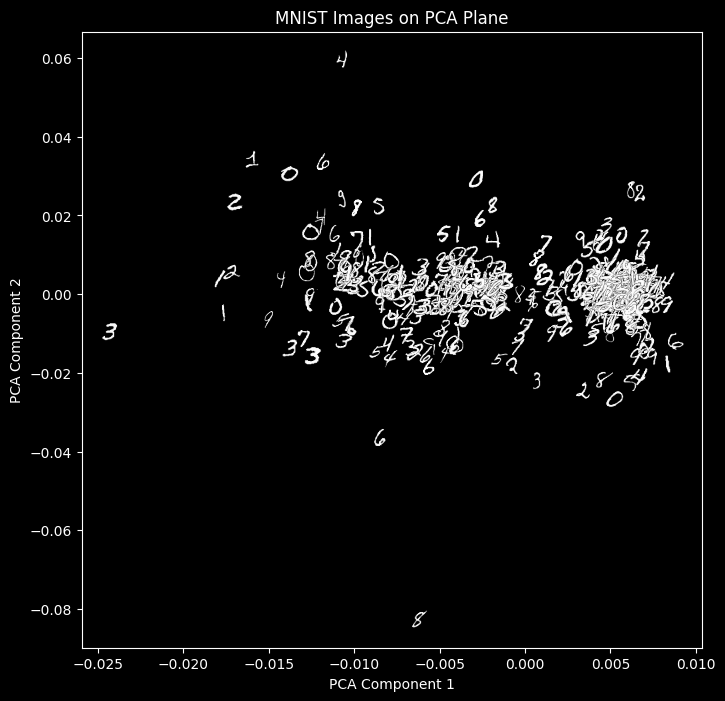

In [50]:
train_and_plot(sample, exp_kernel(1.5), n_show=500)

(500, 2)
(500, 28, 28)


/tmp/ipykernel_7973/492670265.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


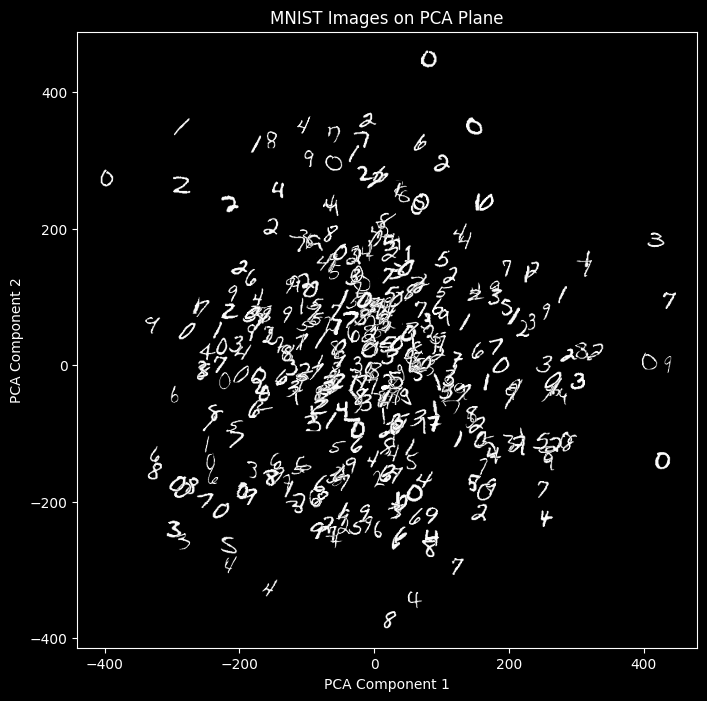

In [58]:
train_and_plot(sample, poly_kernel(1), n_show=500)

(500, 2)
(500, 28, 28)


/tmp/ipykernel_7973/492670265.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


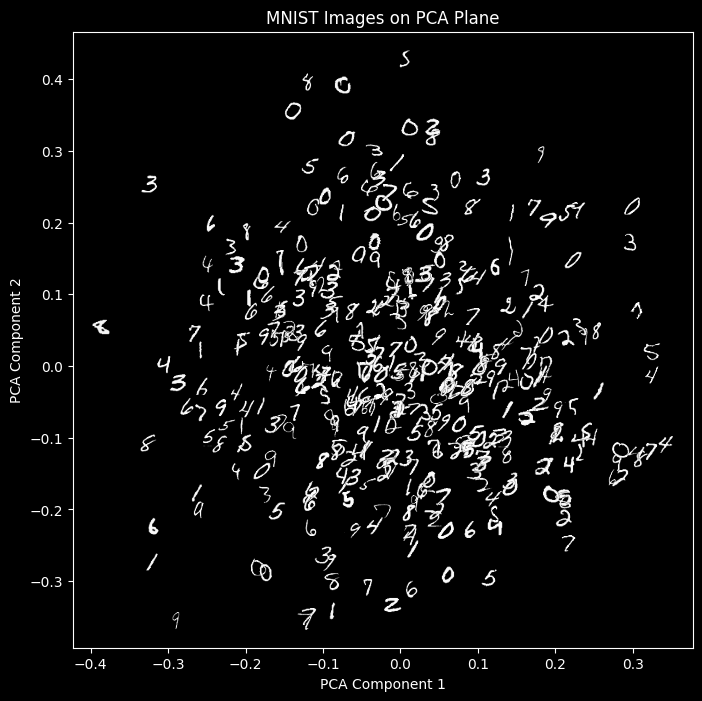

In [69]:
train_and_plot(sample, sigmoid_kernel(0.001, 0), n_show=500)

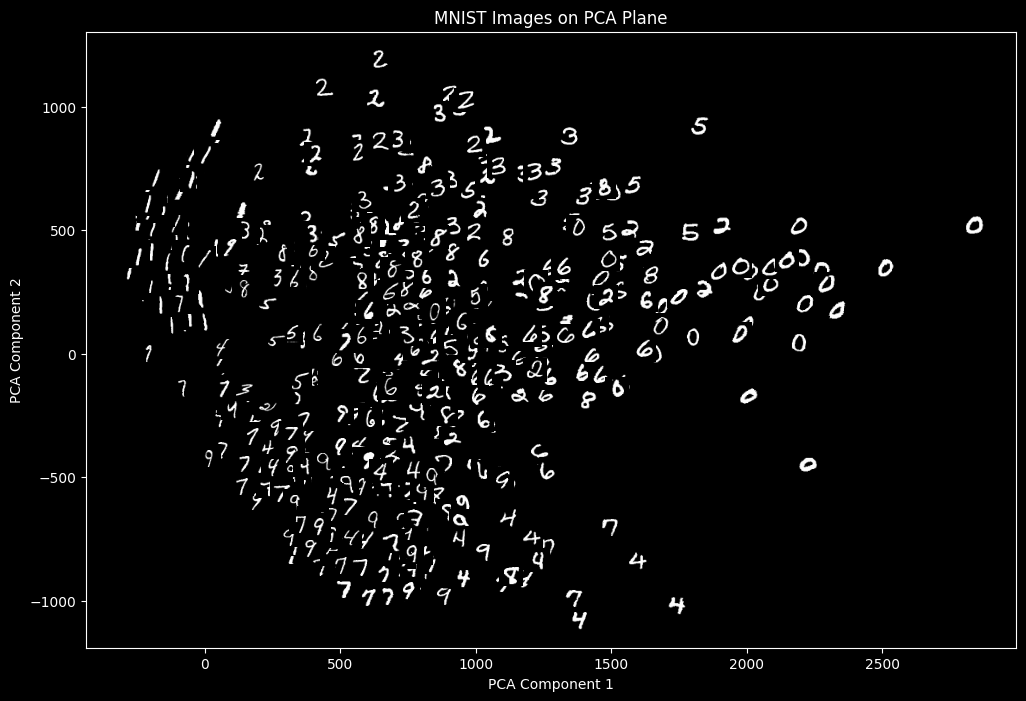

In [4]:

indices = np.random.choice(train_images.shape[0], 500, replace=False)
selected_images = train_images[indices]
selected_images_pca = train_images_pca[indices]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(selected_images_pca[:, 0], selected_images_pca[:, 1])


for i, coords in enumerate(selected_images_pca):
    x, y = coords
    # print(coords)
    img = selected_images[i]
    imagebox = OffsetImage(img, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MNIST Images on PCA Plane')
plt.show()

/tmp/ipykernel_15570/1211740396.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


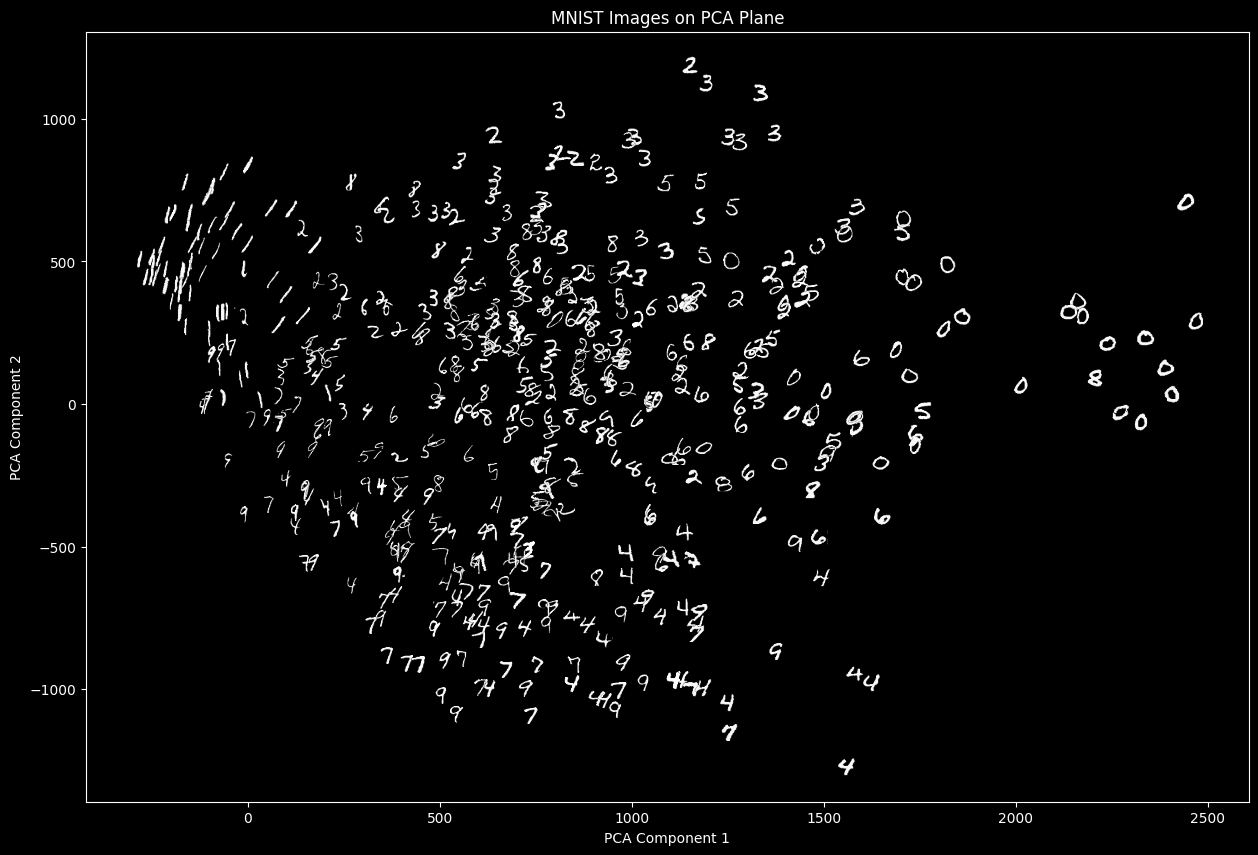

In [5]:
indices = np.random.choice(train_images.shape[0], 500, replace=False)
selected_images = train_images[indices]
selected_images_pca = train_images_pca[indices]

def to_rgba(image, cmap='gray'):
    from matplotlib.cm import get_cmap
    cmap = get_cmap(cmap)
    rgba_img = cmap(image)
    rgba_img[..., 3] = image / 255.0
    return rgba_img

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(selected_images_pca[:, 0], selected_images_pca[:, 1], alpha=0)

for i, coords in enumerate(selected_images_pca):
    x, y = coords
    img = selected_images[i]
    rgba_img = to_rgba(img)
    imagebox = OffsetImage(rgba_img, zoom=0.6)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MNIST Images on PCA Plane')
plt.show()

In [70]:
reconstruction = pca.reconstruct(train_images_pca)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
image_nr = 2

ax[0].imshow(train_images[image_nr], cmap='gray')

ax[1].imshow(reconstruction[image_nr].reshape(28, 28), cmap='gray')
plt.show()


NameError: name 'pca' is not defined

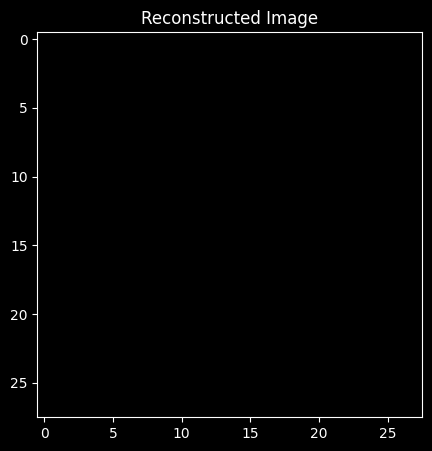

interactive(children=(FloatSlider(value=0.0, description='Component 1', max=1000.0, min=-1000.0, step=1.0), Fl…

FloatSlider(value=0.0, description='Component 1', max=1000.0, min=-1000.0, step=1.0)

FloatSlider(value=0.0, description='Component 2', max=1000.0, min=-1000.0, step=1.0)

In [7]:
import ipywidgets as widgets
from IPython.display import display


# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


def update_plot(component1, component2):
    print(component1, component2)
    components = np.array([[component1, component2]])
    reconstructed_image = pca.reconstruct(components)
    ax.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    # print(reconstructed_image.shape)
    # print(reconstructed_image)
    fig.canvas.draw_idle()

# Create sliders for PCA components
component1_slider = widgets.FloatSlider(value=0, min=-1000, max=1000, step=1, description='Component 1')
component2_slider = widgets.FloatSlider(value=0, min=-1000, max=1000, step=1, description='Component 2')

# Show the initial reconstructed image
initial_components = np.array([[component1_slider.value, component2_slider.value]])
reconstructed_image = pca.reconstruct(initial_components)
ax.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
ax.set_title('Reconstructed Image')

# Create interactive widgets
widgets.interact(update_plot, component1=component1_slider, component2=component2_slider)

plt.show()

# Display sliders
display(component1_slider, component2_slider)


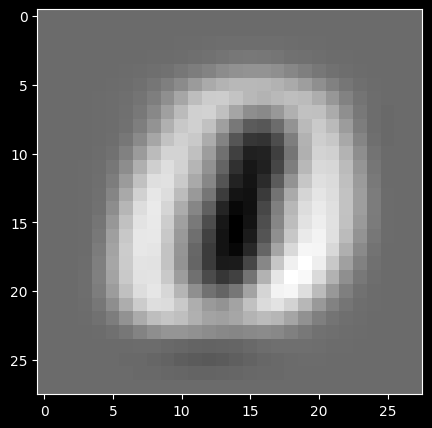

In [70]:
component_1 = 100
component_2 = 0

components = np.array([[component_1, component_2]])
reconstructed_image = pca.reconstruct(components)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(reconstructed_image.reshape(28, 28), cmap='gray')

/tmp/ipykernel_17581/1785111641.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap(cmap)


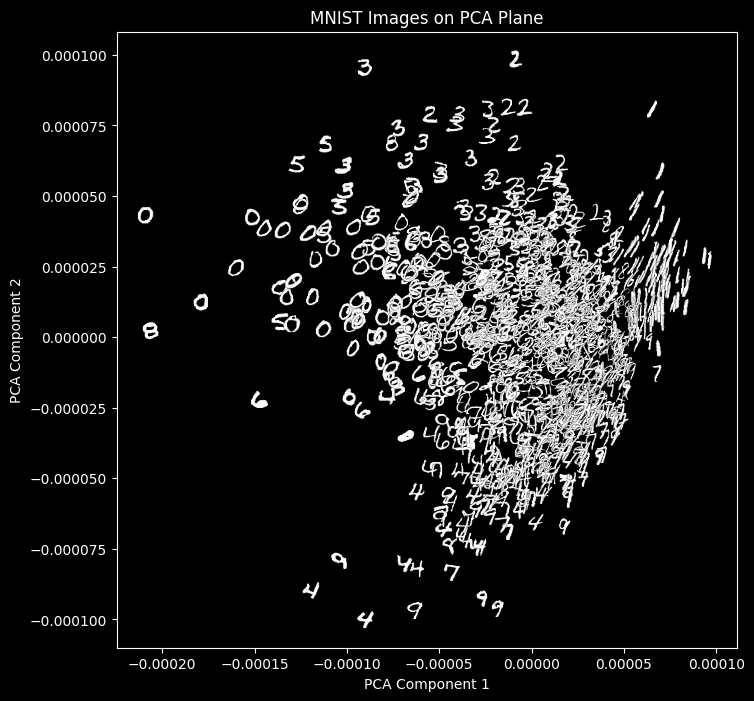

In [67]:
from src.PCA import KPCA
# import jax.numpy as jnp


sample_size = 1000

kpca = KPCA(n_components=2, kernel=rbf_kernel(gamma=0.000000005, z=sample_size))

sample = train_images[np.random.choice(train_images.shape[0], sample_size, replace=False)]
sample = sample.reshape(sample.shape[0], -1)
# sample = jnp.array(sample)

# print(sample.shape)
# print(type(sample))
transformed = kpca.transform(sample)

# print(transformed.shape)
# print(type(transformed))

selected_images = sample.reshape(sample_size, 28, 28)
selected_images_pca = transformed

def to_rgba(image, cmap='gray'):
    from matplotlib.cm import get_cmap
    cmap = get_cmap(cmap)
    rgba_img = cmap(image)
    rgba_img[..., 3] = image / 255.0
    return rgba_img

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(selected_images_pca[:, 0], selected_images_pca[:, 1], alpha=0)

for i, coords in enumerate(selected_images_pca):
    x, y = coords
    img = selected_images[i]
    rgba_img = to_rgba(img)
    imagebox = OffsetImage(rgba_img, zoom=0.6)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('MNIST Images on PCA Plane')
plt.show()